# Aggregating large files with pandas

In [1]:
import pandas as pd
from dfply import *

## Uber data

For this exercise, we will be using the [FiveThirtyEight Uber TLC FOIL data](), be sure that you have download and installed these data.

**Note:** Make sure that you have unzipped the file `./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv.zip`, which should result in the file with the following locaiton: `./data/uber/uber-trip-data/uber-raw-data-janjune-15.csv`.

In [2]:
!git clone https://github.com/fivethirtyeight/uber-tlc-foil-response.git ./data/uber

fatal: destination path './data/uber' already exists and is not an empty directory.


## New Python files

We will be using the following two new python packages.  Insure that you have them both installed and remember to restart the notebook after any installation.

In [4]:
!pip install unpythonic
!pip install macropy3

    100% |████████████████████████████████| 215kB 2.7MB/s ta 0:00:01
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 51kB 1.1MB/s ta 0:00:01
  Stored in directory: /Users/bg8485bw/Library/Caches/pip/wheels/ef/ea/95/65744a6a720d5b0b57779da564c68a3e1b221ea998542a78b3
Successfully built macropy3
You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


# Working with large files

When working with large files,

* Use `chunksize` to get a data frame iterator
    * `chunksize` is the number of rows
`chunksize` is the number of rows
* Iterators are lazy $\rightarrow$ one chunk at a time
* Iterators give you one pass at the data

## General Workflow

* Read chunk $\rightarrow$ process chunk $\rightarrow$ write/aggregate chunk $\rightarrow$ more to next chunk
* Last chunk is lost when you read the next chunk

## Safe operations on big data

* **Aggregate** to a manageable size
* **Filter** to a manageable size
* **Read+Write** Read chuck $\rightarrow$ Process chuck $\rightarrow$ Write chunk
* Use **generator expressions**
    * like list comprehensions, but with `()`
    * More about this at the end of the course

## Big data best practice

* Use `toolz.first` to grab the first chunk
* Prototype on a small chunk of data
* Run your code on all chunks later


## Example 1 - Counting weekday uber pickup frequency

Workflow:
* Create a dataframe iterator
* Prototype by reading/processing the first chunk
    * Get names/types correct
    * Aggregate chunk
* Reset iterator and process all chunks
* Use the accumulator pattern to combine chunk aggregates

## Step 1 - Prototyping your code

* Now build/test your code on a small chunk
* Good general coding technique

#### Create a data frame iterator

In [3]:
c_size = 10000
df_iter = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-apr14.csv",
                      chunksize=c_size)
df_iter

## What is `df_iter`?

* Using `chunksize` $\rightarrow$ dataframe iterator
* Lazily returns chunks of data
* Won't fill up memory

#### Read and prototype on the first chunk

In [4]:
from toolz import first 

first_chunk = first(df_iter)
first_chunk.shape

(10000, 4)

In [5]:
first_chunk.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


#### Making a list of clean names

In [6]:
first_chunk.columns

Index(['Date/Time', 'Lat', 'Lon', 'Base'], dtype='object')

In [7]:
new_names = ['date', 'lat', 'lon', 'base']

#### Inspecting and fixing types

In [8]:
first_chunk.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [9]:
date_cols = ['date']

#### Test by re-reading the data with new parameters

In [10]:
c_size = 10000
date_cols = ['date']
new_names = ['date', 'lat', 'lon', 'base']
df_iter = pd.read_csv("./data/uber-raw-data-apr14.csv", 
                      header=0, names=new_names, # This is now we fix names at read time
                      parse_dates=date_cols,
                      chunksize=c_size)
first_chunk = first(df_iter)
first_chunk.dtypes

date    datetime64[ns]
lat            float64
lon            float64
base            object
dtype: object

In [11]:
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


## Step 2 - Computing the weekday distribution for each chunk

Let's count how many pickups occured on each weekday.  To do this we will

1. Prototype the code on the first chunk;
2. Create helper functions
3. Aggregate all chunks in a comprehension

## What we need to accumplish

1. Add the weekday names
2. Count the frequency for each weekday

#### Prototyping on the first chunk

In [12]:
first_chunk.head()

,date,lat,lon,base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


#### Expression for adding the weekday name to the data frame

In [13]:
from calendar import day_name
weekday_categories = pd.CategoricalDtype(categories=list(day_name),
                                     ordered=True)
(first_chunk 
 >> mutate(weekday = X.date.dt.weekday_name.astype(weekday_categories)) 
 >> head(2))

,date,lat,lon,base,weekday
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512,Tuesday
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512,Tuesday


#### Encapsulate the expression in a helper function and test on first chunk

In [14]:
from functoolz import pipeable
add_weekday = pipeable(lambda df: (df 
                                   >> mutate(weekday = X.date.dt.weekday_name.astype(weekday_categories)) 
                                   >> select(X.date, X.weekday)))
first_chunk >> add_weekday >> head(3)

,date,weekday
0,2014-04-01 00:11:00,Tuesday
1,2014-04-01 00:17:00,Tuesday
2,2014-04-01 00:21:00,Tuesday


#### Expression for chunk aggregation

In [15]:
(first_chunk 
 >> add_weekday 
 >> group_by(X.weekday) 
 >> summarise(cnt = n(X.weekday)))

,weekday,cnt
0,Monday,1376
1,Tuesday,1850
2,Wednesday,1336
3,Thursday,1482
4,Friday,1827
5,Saturday,1309
6,Sunday,820


#### Functions for chunk aggregation

In [16]:
daily_cnts = pipeable(lambda df: (df 
                                  >> group_by(X.weekday) 
                                  >> summarise(cnt = n(X.weekday))))
first_chunk >> add_weekday >> daily_cnts

,weekday,cnt
0,Monday,1376
1,Tuesday,1850
2,Wednesday,1336
3,Thursday,1482
4,Friday,1827
5,Saturday,1309
6,Sunday,820


## Step 3 - Create list of chunk counts

Note that `chunk >> add_weekday >> daily_cnts` 

* Reduces each chunk to a managable size
* It is safe to save all the results

#### Reset  `df_iter`

In [17]:
c_size = 40000
df_iter = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-apr14.csv",
                      header=0, names=new_names, 
                      parse_dates=date_cols,
                      chunksize=c_size,
                      sep = ',',
                      engine = 'python')

#### Watching the paint dry

Without a progress bar, this can be unbearable.

In [18]:
chunk_cnts = [chunk >> add_weekday >> daily_cnts
              for i, chunk in enumerate(df_iter)]

In [19]:
c_size = 40000
df_iter = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-apr14.csv",
                      header=0, names=new_names, 
                      parse_dates=date_cols,
                      chunksize=c_size,
                      sep = ',',
                      engine = 'python')

In [22]:
from unpythonic import begin
chunk_cnts = [begin(print("processing chunk {0}, aggregating {1} rows".format(i, len(chunk))), 
                    chunk >> add_weekday >> daily_cnts)
              for i, chunk in enumerate(df_iter)]

processing chunk 0, aggregating 40000 rows
processing chunk 1, aggregating 40000 rows
processing chunk 2, aggregating 40000 rows
processing chunk 3, aggregating 40000 rows
processing chunk 4, aggregating 40000 rows
processing chunk 5, aggregating 40000 rows
processing chunk 6, aggregating 40000 rows
processing chunk 7, aggregating 40000 rows
processing chunk 8, aggregating 40000 rows
processing chunk 9, aggregating 40000 rows
processing chunk 10, aggregating 40000 rows
processing chunk 11, aggregating 40000 rows
processing chunk 12, aggregating 40000 rows
processing chunk 13, aggregating 40000 rows
processing chunk 14, aggregating 4516 rows


In [21]:
chunk_cnts[2]

,weekday,cnt
0,Monday,3889
1,Tuesday,6327
2,Wednesday,6442
3,Thursday,7418
4,Friday,6213
5,Saturday,5908
6,Sunday,3803


#### Refactored

In [22]:
from unpythonic import begin
print_progress = pipeable(lambda i, chunk: begin(print("processing chunk {0}, aggregating {1} rows".format(i, len(chunk))), chunk))
chunk_cnts = [begin(print_progress(i, chunk),
                    chunk >> add_weekday >> daily_cnts)
              for i, chunk in enumerate(df_iter)]

processing chunk 0, aggregating 40000 rows
processing chunk 1, aggregating 40000 rows
processing chunk 2, aggregating 40000 rows
processing chunk 3, aggregating 40000 rows
processing chunk 4, aggregating 40000 rows
processing chunk 5, aggregating 40000 rows
processing chunk 6, aggregating 40000 rows
processing chunk 7, aggregating 40000 rows
processing chunk 8, aggregating 40000 rows
processing chunk 9, aggregating 40000 rows
processing chunk 10, aggregating 40000 rows
processing chunk 11, aggregating 40000 rows
processing chunk 12, aggregating 40000 rows
processing chunk 13, aggregating 40000 rows
processing chunk 14, aggregating 4516 rows


## Using `begin` to add print statements in an expression

* The expression `begin(print('hi'), expr)` will
    * print hi
    * return the value of expr
* A `begin` expression is the same as the last argument
    * Except print/side-effects
* Nice way to add a progress marker

In [43]:
begin(print('hi'), 2)

hi


2

## Step 3 - Combine the counts with the accumulator pattern

#### Figure out how to combine too chunk counts

In [54]:
cnt1 = chunk_cnts[0]
cnt2 = chunk_cnts[1]

In [55]:
cnt1

,weekday,cnt
0,Monday,3945
1,Tuesday,9609
2,Wednesday,7670
3,Thursday,5493
4,Friday,5552
5,Saturday,4665
6,Sunday,3066


In [56]:
cnt2

,weekday,cnt
0,Monday,5336
1,Tuesday,4781
2,Wednesday,7897
3,Thursday,5499
4,Friday,7151
5,Saturday,5508
6,Sunday,3828


## Combining chunk aggregations

To combine the chunk aggregation

1. `pd.concat` $\rightarrow$ stack the columns
2. Perform another aggregation to combine

#### Concatenating the chunk aggregations

In [57]:
pd.concat([cnt1, cnt2], sort = False) 

,weekday,cnt
0,Monday,3945
1,Tuesday,9609
2,Wednesday,7670
3,Thursday,5493
4,Friday,5552
5,Saturday,4665
6,Sunday,3066
0,Monday,5336
1,Tuesday,4781
2,Wednesday,7897


#### Aggregate to combine counts

In [58]:
(pd.concat([cnt1, cnt2], sort = False) 
 >> group_by(X.weekday) 
 >> summarise(cnt = X.cnt.sum()))

,weekday,cnt
0,Monday,9281
1,Tuesday,14390
2,Wednesday,15567
3,Thursday,10992
4,Friday,12703
5,Saturday,10173
6,Sunday,6894


#### Make a combine helper function

In [59]:
combine = lambda df1, df2: (pd.concat([df1, df2], sort = False) 
                            >> group_by(X.weekday) 
                            >> summarise(cnt = X.cnt.sum()))
combine(cnt1, cnt2)

,weekday,cnt
0,Monday,9281
1,Tuesday,14390
2,Wednesday,15567
3,Thursday,10992
4,Friday,12703
5,Saturday,10173
6,Sunday,6894


## Key-value aggregation

* Example of key-value aggregation
    * **Data:** Key-value pairs
    * **Operation:** group + aggregate
* `spark.RDD` consists of key-value pairs
    * Inspired by `MapReduce`
    * Foundation of all of `spark`/`pyspark`
* Key feature: sums of counts are counts
    * Only works for some aggregations
    * Careful how you combine 

## Key-value Aggregation

<img src="./img/key_value_agg.gif" width=1000>

#### Initialize the accumulator

In [60]:
cnts = chunk_cnts[0]
cnts

,weekday,cnt
0,Monday,3945
1,Tuesday,9609
2,Wednesday,7670
3,Thursday,5493
4,Friday,5552
5,Saturday,4665
6,Sunday,3066


#### Process the remaining chunks

In [61]:
for chunk_cnt in chunk_cnts[1:]:
    cnts = combine(cnts, chunk_cnt)
cnts

,weekday,cnt
0,Monday,60861
1,Tuesday,91185
2,Wednesday,108631
3,Thursday,85067
4,Friday,90303
5,Saturday,77218
6,Sunday,51251


## Visualizing the results

/Users/bn8210wy/.pyenv/versions/anaconda3-5.3.0/lib/python3.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


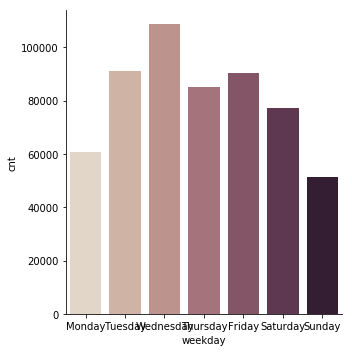

In [62]:
import seaborn as sns
%matplotlib inline

ax = sns.catplot(x="weekday", 
                 y = 'cnt',
                 kind="bar", 
                 palette="ch:.25", 
                 data=cnts)

## Fixing the labels

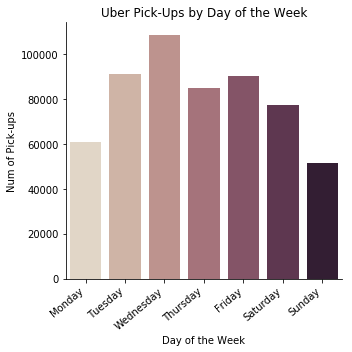

In [64]:
import matplotlib.pylab as plt
ax = (sns
      .catplot(x="weekday", 
               y = 'cnt',
               kind="bar", 
               palette="ch:.25", 
               data=cnts))

ax.set_xticklabels(ax.ax.get_xticklabels(), rotation=40, ha="right")
ax.set(title='Uber Pick-Ups by Day of the Week',
       xlabel='Day of the Week', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## <font color="red"> Exercise 2 </font>

Compute and visualize the hourly frequencies for Uber pick-ups in April 2014.

In [23]:
# Your code here
# Extract hours from dates.
from calendar import day_name
hourly = (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23)
hour_categories = pd.CategoricalDtype(categories=list(hourly),
                                     ordered=True)
(first_chunk 
 >> mutate(hour = X.date.dt.hour.astype(hour_categories)) 
 >> sample(5))


,date,lat,lon,base,hour
6488,2014-04-05 18:57:00,40.7652,-73.9713,B02512,18
8841,2014-04-07 19:14:00,40.7366,-73.9950,B02512,19
2562,2014-04-03 08:24:00,40.7209,-73.9992,B02512,8
3640,2014-04-03 21:38:00,40.7752,-73.9905,B02512,21
9477,2014-04-08 11:24:00,40.7657,-73.9819,B02512,11


In [24]:
# Refactor code into function
from functoolz import pipeable
add_hour = pipeable(lambda df: (df 
                                   >> mutate(hour = X.date.dt.hour.astype(hour_categories)) 
                                   >> select(X.date, X.hour)))
first_chunk >> add_hour >> sample(3)

,date,hour
2141,2014-04-02 20:06:00,20
8659,2014-04-07 18:06:00,18
278,2014-04-01 10:44:00,10


In [25]:
# Expression for chunk aggregration
(first_chunk 
 >> add_hour 
 >> group_by(X.hour) 
 >> summarise(cnt = n(X.hour)))

,hour,cnt
0,0,173
1,1,107
2,2,64
3,3,55
4,4,82
5,5,151
6,6,358
7,7,467
8,8,390
9,9,306


In [26]:
# Function for chunk aggregation
hourly_cnts = pipeable(lambda df: (df 
                                  >> group_by(X.hour) 
                                  >> summarise(cnt = n(X.hour))))
first_chunk >> add_hour >> hourly_cnts

,hour,cnt
0,0,173
1,1,107
2,2,64
3,3,55
4,4,82
5,5,151
6,6,358
7,7,467
8,8,390
9,9,306


In [45]:
c_size = 40000
df_iter = pd.read_csv("./data/uber/uber-trip-data/uber-raw-data-apr14.csv",
                      header=0, names=new_names, 
                      parse_dates=date_cols,
                      chunksize=c_size,
                      sep = ',',
                      engine = 'python')

In [46]:
from unpythonic import begin
print_progress = pipeable(lambda i, chunk: begin(print("processing chunk {0}, aggregating {1} rows".format(i, len(chunk))), chunk))
chunk_cts = [begin(print_progress(i, chunk),
                    chunk >> add_hour >> hourly_cnts)
              for i, chunk in enumerate(df_iter)]

processing chunk 0, aggregating 40000 rows
processing chunk 1, aggregating 40000 rows
processing chunk 2, aggregating 40000 rows
processing chunk 3, aggregating 40000 rows
processing chunk 4, aggregating 40000 rows
processing chunk 5, aggregating 40000 rows
processing chunk 6, aggregating 40000 rows
processing chunk 7, aggregating 40000 rows
processing chunk 8, aggregating 40000 rows
processing chunk 9, aggregating 40000 rows
processing chunk 10, aggregating 40000 rows
processing chunk 11, aggregating 40000 rows
processing chunk 12, aggregating 40000 rows
processing chunk 13, aggregating 40000 rows
processing chunk 14, aggregating 4516 rows


In [47]:
ct1 = chunk_cts[0]
ct2 = chunk_cts[1]

In [54]:
combine = lambda df1, df2: (pd.concat([df1, df2], sort = False) 
                            >> group_by(X.hour) 
                            >> summarise(cnt = X.cnt.sum()))
combine(ct1, ct2)

,hour,cnt
0,0,1564
1,1,919
2,2,558
3,3,606
4,4,792
5,5,1298
6,6,2752
7,7,3678
8,8,3209
9,9,2551


In [65]:
cts = chunk_cts[0]
cts.cnt.sum()

40000

In [68]:
for chunk in chunk_cts[1:]:
    cts = combine(cts, chunk_cnt)
cts

,hour,cnt
0,0,4697
1,1,3626
2,2,2147
3,3,1994
4,4,1959
5,5,2762
6,6,5599
7,7,8360
8,8,7517
9,9,5672


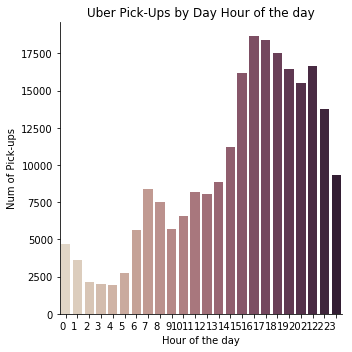

In [72]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

ax = sns.catplot(x="hour", 
                 y = 'cnt',
                 kind="bar", 
                 palette="ch:.25", 
                 data=cts)


ax.set_xticklabels(ax.ax.get_xticklabels(),ha="right")
ax.set(title='Uber Pick-Ups by Day Hour of the day',
       xlabel='Hour of the day', 
       ylabel='Num of Pick-ups')
plt.tight_layout()
plt.show()

## Up Next

In [Lecture 3.3](./3_3_reading_processing_and_writing_large_files.ipynb), we will look an a second option for working with large files, which involves reading, processing, then writing each chunk to a new file.